In [1]:
import sys
from pathlib import Path

sys.path.insert(0, str(Path().cwd().parent.parent))

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Callable
from scipy.stats import pearsonr
from sklearn.model_selection import train_test_split, KFold, cross_validate
from sklearn.feature_selection import mutual_info_regression
from sklearn.preprocessing import FunctionTransformer, StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.compose import ColumnTransformer, make_column_selector, TransformedTargetRegressor
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import rbf_kernel
from sklearn.utils.validation import check_is_fitted, check_array
from sklearn import linear_model, ensemble
from xgboost import XGBRegressor
import joblib
import warnings


from analysis.gcp.files import gcs
from analysis.gcp.storage import gcp

pd.set_option('display.max_columns', None)
sns.set_theme(style='white', context='notebook', palette='deep')
warnings.filterwarnings('ignore')

In [2]:
df = gcs.read_csv('wage_vals_stats/forwards.csv')

## Split data

In [3]:
train_set = df.loc[df['season'] != 2023]
season_2023 = df.loc[df['season'] == 2023]
valid_set, test_set = train_test_split(season_2023, test_size=0.5, stratify=season_2023['position'], random_state=42)

In [4]:
def count_null_features(df: pd.DataFrame) -> pd.DataFrame:
    nulls = df.isnull().sum()
    mask = nulls > 0
    return len(nulls[mask])

In [5]:
count_null_features(train_set), count_null_features(valid_set), count_null_features(test_set)

(65, 14, 12)

## Preprocessing

In [6]:
def create_youth_player_col(df: pd.DataFrame) -> pd.DataFrame:
    def youth_player(x: pd.Series) -> bool:
        if pd.isna(x["squad"]) or pd.isna(x["signed_from"]):
            return 'False'

        squad_words = x["squad"].split()  # Split squad name into words

        for word in squad_words:
            if word in x["signed_from"]:
                return 'True'
            else:
                return 'False'
            
    df['is_youth_player'] = df.apply(youth_player, axis=1)
    return df

In [7]:
def impute_signing_fee(df: pd.DataFrame) -> pd.DataFrame:
    data = df.copy()
    
    data.loc[data['is_youth_player'] == 'True', 'signing_fee_euro_mill'] = 0
    
    data.loc[:, "signing_fee_euro_mill"] = data["signing_fee_euro_mill"].fillna(
        data.groupby(["league", "age"])["signing_fee_euro_mill"].transform(
            "median"
        )
    )
    return data

In [8]:
def impute_market_value(df: pd.DataFrame) -> pd.DataFrame:
    data = df.copy()
    data.loc[:, "market_value_euro_mill"] = data["market_value_euro_mill"].fillna(
        data.groupby(["league", "age"])["market_value_euro_mill"].transform("median")
    )
    return data

In [9]:
def impute_signed_from(df: pd.DataFrame) -> pd.DataFrame:
    data = df.copy()
    data.loc[:, "signed_from"] = data["signed_from"].fillna("Unknown")
    return data 

In [10]:
def impute_signed_year(df: pd.DataFrame) -> pd.DataFrame:
    data = df.copy()
    data.loc[:, "signed_year"] = data["signed_year"].fillna(data['season'])
    return data

In [11]:
def impute_foot(df: pd.DataFrame) -> pd.DataFrame:
    data = df.copy()
    data.loc[:, 'foot'] = data['foot'].fillna(data['foot'].mode()[0])   
    return data

In [12]:
def impute_goals_per_shot_on_target(df: pd.DataFrame) -> pd.DataFrame:
    data = df.copy()
    data.loc[data['shots_on_target'] == 0, 'goals_per_shot_on_target'] = 0
    return data

In [13]:
def impute_avg_shot_distance(df: pd.DataFrame) -> pd.DataFrame:
    data = df.copy()
    data.loc[data["shots"] == 0, "avg_shot_distance"] = 0
    
    data.loc[:, "avg_shot_distance"] = data["avg_shot_distance"].fillna(
        data.groupby("position")["avg_shot_distance"].transform("median")
    )
    return data

In [14]:
def impute_goals_per_shot(df: pd.DataFrame) -> pd.DataFrame:
    data = df.copy()
    data.loc[data['shots'] == 0, 'goals_per_shot'] = 0
    return data

In [15]:
def impute_shots_on_target_pct(df: pd.DataFrame) -> pd.DataFrame:
    data = df.copy()
    data.loc[data['shots'] == 0, 'shots_on_target_pct'] = 0
    return data

In [16]:
def impute_long_pass_comp_pct(df: pd.DataFrame) -> pd.DataFrame:
    data = df.copy()
    data.loc[data['long_passes_attempted'] == 0, 'long_pass_completion_pct'] = 0
    return data

In [17]:
def impute_medium_pass_comp_pct(df: pd.DataFrame) -> pd.DataFrame:
    data = df.copy()
    data.loc[data['medium_passes_attempted'] == 0, 'medium_pass_completion_pct'] = 0
    return data

In [18]:
def impute_short_pass_comp_pct(df: pd.DataFrame) -> pd.DataFrame:
    data = df.copy()
    data.loc[data['short_passes_attempted'] == 0, 'short_pass_completion_pct'] = 0
    return data

In [19]:
def impute_pass_comp_pct(df: pd.DataFrame) -> pd.DataFrame:
    data = df.copy()
    data.loc[data['passes_attempted'] == 0, 'pass_completion_pct'] = 0
    return data

In [20]:
def remove_remaining_nulls(df: pd.DataFrame) -> pd.DataFrame:
    data = df.copy()
    data = data.dropna()
    return data

In [21]:
def drop_columns(df: pd.DataFrame) -> pd.DataFrame:
    drop_cols = [
        'player',
        'country',
        'signed_from',
        'squad',
        'player_id',
        'annual_wages_euros',
        'age_range',
        'rk',
        'nation',
        'pos',
        'comp',
        'born',
        'general_pos',
        'is_youth_player',
        'signing_fee_euro_mill',
        'weekly_wages_euros'
        ]
    return df.drop(columns=drop_cols)

In [22]:

def preprocessor(df: pd.DataFrame) -> pd.DataFrame:
    data = df.copy()
    return (
        data.pipe(create_youth_player_col)
        .pipe(impute_signing_fee)
        .pipe(impute_market_value)
        .pipe(impute_signed_from)
        .pipe(impute_signed_year)
        .pipe(impute_foot)
        .pipe(impute_goals_per_shot_on_target)
        .pipe(impute_avg_shot_distance)
        .pipe(impute_goals_per_shot)
        .pipe(impute_shots_on_target_pct)
        .pipe(impute_long_pass_comp_pct)
        .pipe(impute_medium_pass_comp_pct)
        .pipe(impute_short_pass_comp_pct)
        .pipe(impute_pass_comp_pct)
        .pipe(remove_remaining_nulls)
        .pipe(drop_columns)
    )

In [23]:
train_set_ = preprocessor(train_set)
valid_set_ = preprocessor(valid_set)
test_set_ = preprocessor(test_set)
season_2023_ = preprocessor(season_2023)

In [24]:
train_set_.shape, valid_set_.shape, test_set_.shape

((12283, 74), (896, 74), (898, 74))

## Correlation Analysis

In [25]:
corrs = train_set_.corr(numeric_only=True)
y_corrs = corrs.loc[:,'market_value_euro_mill'].sort_values(ascending=False).reset_index()
y_corrs.style.background_gradient(cmap='coolwarm')

,index,market_value_euro_mill
0,market_value_euro_mill,1.000000
1,goal_creating_actions,0.546827
2,pass_live_gca,0.533358
3,shots_on_target,0.504075
4,goals,0.496696
5,pass_live_sca,0.496484
6,shots,0.492693
7,shot_creating_actions,0.484024
8,xa,0.477499
9,xag,0.477167


In [26]:
def corr_significance(df: pd.DataFrame, y_var: str):
    num_cols = df.select_dtypes(include="number").columns

    def calculate_corr(col: str, i: int):
        return round(pearsonr(df[col], df[y_var])[i], 4)

    stats = [
        {
            "Variable": col,
            "correlation": calculate_corr(col, 0),
            "p-value": calculate_corr(col, 1),
            "significant": True if calculate_corr(col, 1) < 0.05 else False,
        }
        for col in num_cols
    ]
    return (
        pd.DataFrame(stats)
        .sort_values(by="correlation", ascending=False)
        .reset_index(drop=True)
    )

In [27]:
corr_sig_df = corr_significance(train_set_, y_var="market_value_euro_mill")

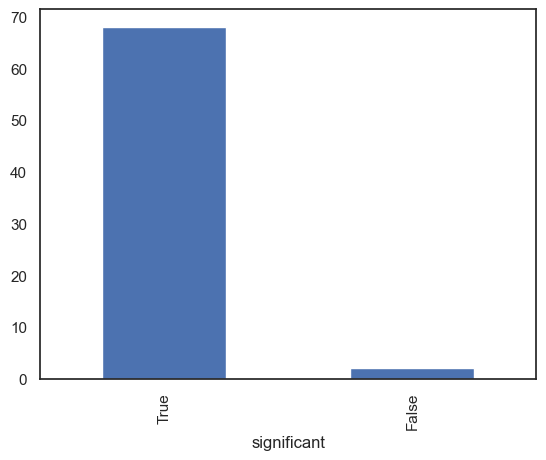

In [28]:
corr_sig_df['significant'].value_counts().plot(kind='bar')
plt.show()

## Mutual Information score

In [29]:
def factorize_cats(X: pd.DataFrame) -> tuple[pd.DataFrame, pd.Series]:
    for colname in X.select_dtypes(["object"]):
        X[colname], _ = X[colname].factorize()

    discrete_features = X.dtypes == int
    
    return X, discrete_features

In [30]:
def create_mi_scores(X: pd.DataFrame, y: pd.Series) -> pd.Series:
    X_factored, discrete_features = factorize_cats(X)
    mi_scores = mutual_info_regression(X_factored, y, discrete_features=discrete_features).round(2)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

In [31]:
X = train_set_.drop(columns="market_value_euro_mill")
y = train_set_["market_value_euro_mill"]

In [32]:
mi_scores = create_mi_scores(X, y)

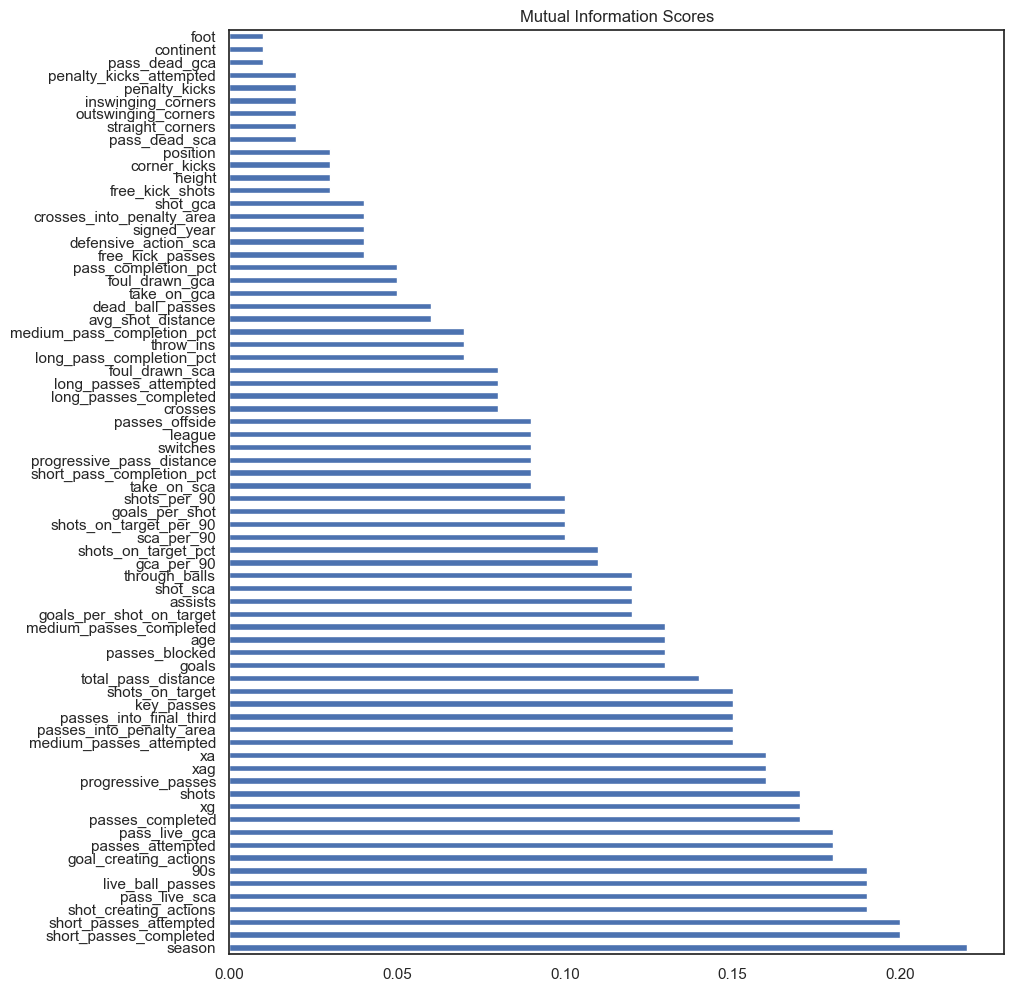

In [33]:
mask = mi_scores > 0.00
plt.subplots(figsize=(10, 12))
mi_scores[mask].plot(kind='barh')
plt.title('Mutual Information Scores')
plt.show()

## Model building

In [34]:
MLA = [
    linear_model.LinearRegression(),
    linear_model.Lasso(),
    linear_model.Ridge(),
    linear_model.ElasticNet(),
    ensemble.RandomForestRegressor(),
    ensemble.GradientBoostingRegressor(),
    XGBRegressor()
]

In [35]:
cv = KFold(n_splits=5, shuffle=True, random_state=42)

In [36]:
def evaluate_model(
    model: BaseEstimator, X: pd.DataFrame, y: pd.Series, cv: KFold, index: int
) -> pd.Series:
    
    print(f"Training {model['model'].__class__.__name__}")

    cols = ["name", "parameters", "train_mae", "test_mae", "test_std", "training_time"]

    mla_df = pd.DataFrame(columns=cols)

    cv_results = cross_validate(
        model, X, y, cv=cv, scoring="neg_mean_absolute_error", n_jobs=-1, return_train_score=True
    )
    
    print(cv_results)

    mla_df.loc[index, "name"] = model['model'].__class__.__name__
    mla_df.loc[index, "parameters"] = str(model.get_params())
    mla_df.loc[index, "train_mae"] = -cv_results["train_score"].mean()
    mla_df.loc[index, "test_mae"] = -cv_results["test_score"].mean()
    mla_df.loc[index, "test_std"] = cv_results["test_score"].std()
    mla_df.loc[index, "training_time"] = cv_results["fit_time"].mean()

    return mla_df

In [37]:
def compare_predictions(
    model: Pipeline, X: pd.DataFrame, y: pd.Series
) -> pd.DataFrame:
    model.fit(X, y)
    y_pred = model.predict(X)
    model_name = model['model'].__class__.__name__
    return pd.DataFrame({model_name: y_pred})

In [38]:
def preprocessor() -> ColumnTransformer:
    return ColumnTransformer([
            ("cat", OneHotEncoder(handle_unknown='ignore'), make_column_selector(dtype_include=object)),
        ], remainder='passthrough')

In [39]:
def model_pipe(model: RegressorMixin) -> Pipeline:
    return Pipeline([("preprocessor", preprocessor()), ("model", model)])

In [40]:
X_, y_ = train_set_.drop(columns="market_value_euro_mill"), train_set_["market_value_euro_mill"]

In [41]:
pipe = [evaluate_model(model_pipe(model), X_, y_, cv, i) for i, model in enumerate(MLA)]

Training LinearRegression
{'fit_time': array([0.09081912, 0.09988403, 0.09548783, 0.12065792, 0.10428905]), 'score_time': array([0.00464392, 0.00363588, 0.0040381 , 0.010463  , 0.00498486]), 'test_score': array([-6.79625154, -6.67723808, -6.84313494, -6.71298617, -7.05087711]), 'train_score': array([-6.69653632, -6.76242608, -6.77644296, -6.75509546, -6.67028696])}
Training Lasso


/Users/conal/Projects/fpl_app/analytics/.venv/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.037e+05, tolerance: 2.685e+02
  model = cd_fast.enet_coordinate_descent(
/Users/conal/Projects/fpl_app/analytics/.venv/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.405e+05, tolerance: 2.746e+02
  model = cd_fast.enet_coordinate_descent(
/Users/conal/Projects/fpl_app/analytics/.venv/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check t

{'fit_time': array([0.83114409, 0.81347299, 0.88531184, 0.86674309, 0.89452887]), 'score_time': array([0.00335407, 0.00330281, 0.00327921, 0.00335526, 0.00362325]), 'test_score': array([-7.10344268, -6.92891591, -6.92064111, -7.0621508 , -7.08225323]), 'train_score': array([-6.94308999, -7.00131512, -7.0455004 , -6.98730695, -6.94301621])}
Training Ridge
{'fit_time': array([0.02186608, 0.02433205, 0.02413011, 0.018924  , 0.02524614]), 'score_time': array([0.00369191, 0.00335693, 0.00341702, 0.00903296, 0.00302291]), 'test_score': array([-6.79656159, -6.67689117, -6.84270524, -6.71191486, -7.04984041]), 'train_score': array([-6.69657454, -6.76201627, -6.77607863, -6.75367412, -6.66991713])}
Training ElasticNet


/Users/conal/Projects/fpl_app/analytics/.venv/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.156e+05, tolerance: 2.657e+02
  model = cd_fast.enet_coordinate_descent(
/Users/conal/Projects/fpl_app/analytics/.venv/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.334e+05, tolerance: 2.688e+02
  model = cd_fast.enet_coordinate_descent(
/Users/conal/Projects/fpl_app/analytics/.venv/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check t

{'fit_time': array([0.86192298, 0.86348605, 0.92868567, 0.92069411, 0.93460894]), 'score_time': array([0.00347304, 0.0034771 , 0.00333428, 0.00335002, 0.00347805]), 'test_score': array([-7.09655779, -6.91825105, -6.9230475 , -7.06427164, -7.10265657]), 'train_score': array([-6.93929531, -7.01228399, -7.03998035, -6.98401176, -6.94065756])}
Training RandomForestRegressor
{'fit_time': array([25.519449  , 25.39532804, 25.52581191, 25.30259085, 25.37690496]), 'score_time': array([0.04619098, 0.04567909, 0.04584408, 0.04548502, 0.04462004]), 'test_score': array([-5.61802956, -5.74028032, -5.55784595, -5.68965253, -5.82851181]), 'train_score': array([-2.11732648, -2.10629022, -2.11026739, -2.11387651, -2.09021882])}
Training GradientBoostingRegressor
{'fit_time': array([6.27045512, 6.24056602, 6.23852801, 6.1995821 , 6.21306396]), 'score_time': array([0.00617075, 0.00607896, 0.00590515, 0.006145  , 0.00566506]), 'test_score': array([-5.63507824, -5.78727777, -5.72486884, -5.66709227, -6.0296

In [42]:
results = pd.concat(pipe)
results

,name,parameters,train_mae,test_mae,test_std,training_time
0,LinearRegression,"{'memory': None, 'steps': [('preprocessor', Co...",6.732158,6.816098,0.131271,0.102228
1,Lasso,"{'memory': None, 'steps': [('preprocessor', Co...",6.984046,7.019481,0.078463,0.85824
2,Ridge,"{'memory': None, 'steps': [('preprocessor', Co...",6.731652,6.815583,0.131116,0.0229
3,ElasticNet,"{'memory': None, 'steps': [('preprocessor', Co...",6.983246,7.020957,0.082947,0.90188
4,RandomForestRegressor,"{'memory': None, 'steps': [('preprocessor', Co...",2.107596,5.686864,0.094137,25.424017
5,GradientBoostingRegressor,"{'memory': None, 'steps': [('preprocessor', Co...",5.143996,5.768784,0.140367,6.232439
6,XGBRegressor,"{'memory': None, 'steps': [('preprocessor', Co...",2.117754,5.590277,0.072312,0.561575


In [43]:
preds = pd.concat([compare_predictions(model_pipe(model), X_, y_) for model in MLA], axis=1)
preds.loc[:, "market_value_euro_mill"] = y_

In [44]:
preds

,LinearRegression,Lasso,Ridge,ElasticNet,RandomForestRegressor,GradientBoostingRegressor,XGBRegressor,market_value_euro_mill
0,1.060248,1.308459,1.031960,2.060189,25.28350,1.600644,19.917049,35.000
1,10.900330,13.646690,10.880667,13.391394,7.67500,13.894184,5.826842,6.000
2,-7.040577,-4.188828,-7.065745,-4.000873,0.21550,-1.787197,-0.300326,0.100
3,25.497233,24.609828,25.640698,25.087129,51.10500,29.006438,52.626987,60.000
4,16.556396,18.380421,16.614327,18.792704,38.39100,14.994863,40.187241,50.000
...,...,...,...,...,...,...,...,...
12278,-2.805602,2.298785,-2.762890,2.241711,1.74825,1.195644,1.064366,0.475
12279,15.929028,20.336837,15.921597,20.447503,4.02400,7.452767,9.220873,0.475
12280,-8.482972,-3.442077,-8.475227,-3.606195,1.28300,-0.461576,-0.512226,0.400
12281,0.890467,4.975117,0.917187,4.732081,1.57100,2.059627,-0.007876,2.400


In [45]:
def correlation_heatmap(df: pd.DataFrame) -> None:
    _ , ax = plt.subplots(figsize =(14, 12))
    colormap = sns.diverging_palette(220, 10, as_cmap = True)
    
    _ = sns.heatmap(
        df.corr(), 
        cmap = colormap,
        square=True, 
        cbar_kws={'shrink':.9 }, 
        ax=ax,
        annot=True, 
        linewidths=0.1,vmax=1.0, linecolor='white',
        annot_kws={'fontsize':12 }
    )
    
    plt.title('Pearson Correlation of Features', y=1.05, size=15)

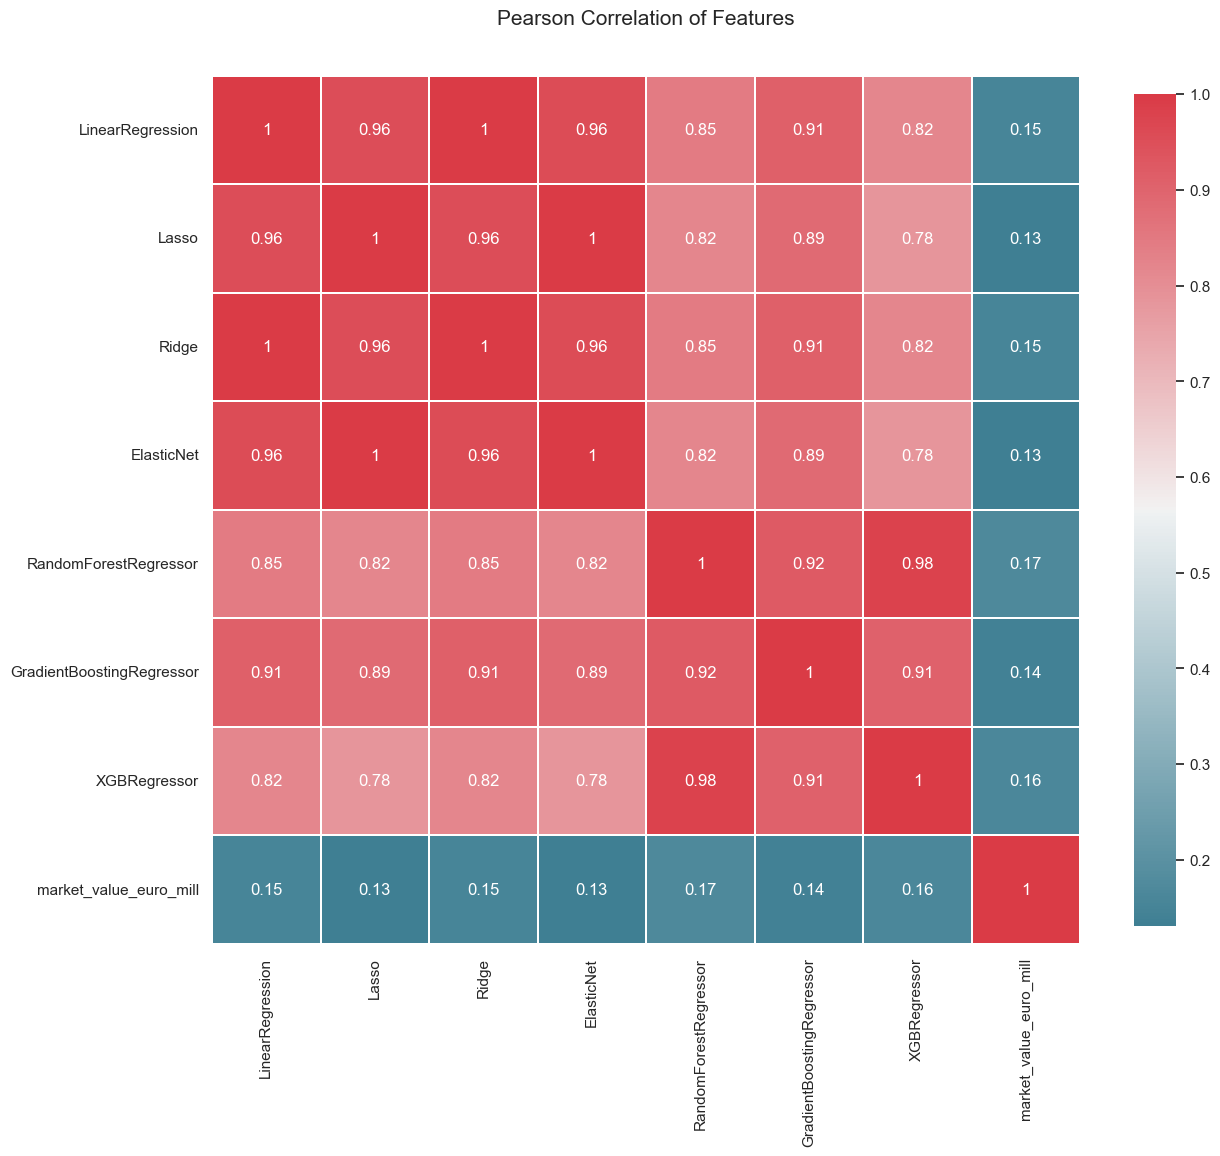

In [46]:
correlation_heatmap(preds)

In [47]:
preds

,LinearRegression,Lasso,Ridge,ElasticNet,RandomForestRegressor,GradientBoostingRegressor,XGBRegressor,market_value_euro_mill
0,1.060248,1.308459,1.031960,2.060189,25.28350,1.600644,19.917049,35.000
1,10.900330,13.646690,10.880667,13.391394,7.67500,13.894184,5.826842,6.000
2,-7.040577,-4.188828,-7.065745,-4.000873,0.21550,-1.787197,-0.300326,0.100
3,25.497233,24.609828,25.640698,25.087129,51.10500,29.006438,52.626987,60.000
4,16.556396,18.380421,16.614327,18.792704,38.39100,14.994863,40.187241,50.000
...,...,...,...,...,...,...,...,...
12278,-2.805602,2.298785,-2.762890,2.241711,1.74825,1.195644,1.064366,0.475
12279,15.929028,20.336837,15.921597,20.447503,4.02400,7.452767,9.220873,0.475
12280,-8.482972,-3.442077,-8.475227,-3.606195,1.28300,-0.461576,-0.512226,0.400
12281,0.890467,4.975117,0.917187,4.732081,1.57100,2.059627,-0.007876,2.400


## hyperparameter tune

## predict

## save to gcp

In [48]:
rf = MLA[4]
model = model_pipe(rf)
model.fit(X_, y_)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x16c2819d0>)])),
                ('model', RandomForestRegressor())])

In [49]:
X_test__ = season_2023_.drop(columns="market_value_euro_mill")
preds_2023 = model.predict(X_test__)

In [50]:
idx = season_2023_.index.to_numpy()
preds_2023 = pd.Series(preds_2023, name='market_value_prediction', index=idx)
pred_df = season_2023[['player', 'position', 'foot', 'comp', 'squad', 'country', 'weekly_wages_euros', 'market_value_euro_mill']].join(preds_2023)

In [51]:
pred_df.sort_values('market_value_prediction', ascending=False).head(20)

,player,position,foot,comp,squad,country,weekly_wages_euros,market_value_euro_mill,market_value_prediction
2280,Florian Wirtz,Attacking-Midfield,right,Bundesliga,Leverkusen,Germany,48077,100.0,57.985
2284,Victor Boniface,Centre-Forward,right,Bundesliga,Leverkusen,Nigeria,38462,40.0,54.620
4798,Jude Bellingham,Attacking-Midfield,right,La Liga,Real Madrid,England,400577,180.0,52.255
10710,James Maddison,Attacking-Midfield,right,Premier League,Tottenham,England,197780,70.0,52.195
10630,Bukayo Saka,Right-Winger,left,Premier League,Arsenal,England,226865,120.0,51.690
10604,Rodri,Defensive-Midfield,right,Premier League,Manchester City,Spain,255951,110.0,51.430
10625,Martin Ødegaard,Attacking-Midfield,left,Premier League,Arsenal,Norway,279219,90.0,49.637
10610,Phil Foden,Right-Winger,left,Premier League,Manchester City,England,261768,110.0,48.975
10763,Ollie Watkins,Centre-Forward,right,Premier League,Aston Villa,England,151244,60.0,48.605
2263,Leroy Sané,Right-Winger,left,Bundesliga,Bayern Munich,Germany,384615,80.0,48.400


In [53]:
gcp.write_df_to_bucket_parquet(data=pred_df, bucket_name='values_predictions', blob_name='attacking_stats.parquet')

[06/07/24 20:51:11] INFO     analysis.gcp.storage - [ MainThread:get_gcp_bucket:29 ] - Getting GCP bucket                                ]8;id=625574;file:///Users/conal/Projects/fpl_app/analytics/analysis/gcp/storage.py\storage.py]8;;\:]8;id=810404;file:///Users/conal/Projects/fpl_app/analytics/analysis/gcp/storage.py#29\29]8;;\

                    INFO     analysis.gcp.storage - [ MainThread:get_gcp_bucket:34 ] - GCP bucket retrieved                              ]8;id=789009;file:///Users/conal/Projects/fpl_app/analytics/analysis/gcp/storage.py\storage.py]8;;\:]8;id=969368;file:///Users/conal/Projects/fpl_app/analytics/analysis/gcp/storage.py#34\34]8;;\

                    INFO     analysis.gcp.storage - [ MainThread:write_df_to_bucket_parquet:128 ] - Creating blob:                      ]8;id=11848;file:///Users/conal/Projects/fpl_app/analytics/analysis/gcp/storage.py\storage.py]8;;\:]8;id=639423;file:///Users/conal/Projects/fpl_app/analytics/analysis/gcp/storage.py#128\128]8;;\
                             attacking_stats.parquet                                                                                                  

                    INFO     analysis.gcp.storage - [ MainThread:write_df_to_bucket_parquet:131 ] - Uploading dataframe to              ]8;id=784329;file:///Users/conal/Projects/fpl_app/analytics/analysis/gcp/storage.py\storage.py]8;;\:]8;id=597412;file:///Users/conal/Projects/fpl_app/analytics/analysis/gcp/storage.py#131\131]8;;\
                             attacking_stats.parquet as a .parquet file                                                                               